# Desafio 5

Neste desafio, vamos praticar sobre redução de dimensionalidade com PCA e seleção de variáveis com RFE. Utilizaremos o _data set_ [Fifa 2019](https://www.kaggle.com/karangadiya/fifa19), contendo originalmente 89 variáveis de mais de 18 mil jogadores do _game_ FIFA 2019.

> Obs.: Por favor, não modifique o nome das funções de resposta.

## _Setup_ geral

In [1]:
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sct
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats as st
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from loguru import logger
from IPython import get_ipython
from IPython.core.pylabtools import figsize
from yellowbrick.features import PCA as yPCA


figsize(12, 8)
sns.set()

In [2]:
fifa = pd.read_csv("fifa.csv")

In [3]:
columns_to_drop = ["Unnamed: 0", "ID", "Name", "Photo", "Nationality", "Flag",
                   "Club", "Club Logo", "Value", "Wage", "Special", "Preferred Foot",
                   "International Reputation", "Weak Foot", "Skill Moves", "Work Rate",
                   "Body Type", "Real Face", "Position", "Jersey Number", "Joined",
                   "Loaned From", "Contract Valid Until", "Height", "Weight", "LS",
                   "ST", "RS", "LW", "LF", "CF", "RF", "RW", "LAM", "CAM", "RAM", "LM",
                   "LCM", "CM", "RCM", "RM", "LWB", "LDM", "CDM", "RDM", "RWB", "LB", "LCB",
                   "CB", "RCB", "RB", "Release Clause"
]

try:
    fifa.drop(columns_to_drop, axis=1, inplace=True)
except KeyError:
    logger.warning(f"Columns already dropped")

## Inicia sua análise a partir daqui

In [4]:
fifa.describe()

Age       Overall     Potential      Crossing     Finishing  \
count  18207.000000  18207.000000  18207.000000  18159.000000  18159.000000   
mean      25.122206     66.238699     71.307299     49.734181     45.550911   
std        4.669943      6.908930      6.136496     18.364524     19.525820   
min       16.000000     46.000000     48.000000      5.000000      2.000000   
25%       21.000000     62.000000     67.000000     38.000000     30.000000   
50%       25.000000     66.000000     71.000000     54.000000     49.000000   
75%       28.000000     71.000000     75.000000     64.000000     62.000000   
max       45.000000     94.000000     95.000000     93.000000     95.000000   

       HeadingAccuracy  ShortPassing       Volleys     Dribbling  \
count     18159.000000  18159.000000  18159.000000  18159.000000   
mean         52.298144     58.686712     42.909026     55.371001   
std          17.379909     14.699495     17.694408     18.910371   
min           4.000000      7.000000      4.000000      4.000000   
25%          44.000000     54.000000     30.000000     49.000000   
50%          56.000000     62.000000     44.000000     61.000000   
75%          64.000000     68.000000     57.000000     68.000000   
max          94.000000     93.000000     90.000000     97.000000   

              Curve  ...     Penalties     Composure       Marking  \
count  18159.000000  ...  18159.000000  18159.000000  18159.000000   
mean      47.170824  ...     48.548598     58.648274     47.281623   
std       18.395264  ...     15.704053     11.436133     19.904397   
min        6.000000  ...      5.000000      3.000000      3.000000   
25%       34.000000  ...     39.000000     51.000000     30.000000   
50%       48.000000  ...     49.000000     60.000000     53.000000   
75%       62.000000  ...     60.000000     67.000000     64.000000   
max       94.000000  ...     92.000000     96.000000     94.000000   

       StandingTackle  SlidingTackle      GKDiving    GKHandling  \
count    18159.000000   18159.000000  18159.000000  18159.000000   
mean        47.697836      45.661435     16.616223     16.391596   
std         21.664004      21.289135     17.695349     16.906900   
min          2.000000       3.000000      1.000000      1.000000   
25%         27.000000      24.000000      8.000000      8.000000   
50%         55.000000      52.000000     11.000000     11.000000   
75%         66.000000      64.000000     14.000000     14.000000   
max         93.000000      91.000000     90.000000     92.000000   

          GKKicking  GKPositioning    GKReflexes  
count  18159.000000   18159.000000  18159.000000  
mean      16.232061      16.388898     16.710887  
std       16.502864      17.034669     17.955119  
min        1.000000       1.000000      1.000000  
25%        8.000000       8.000000      8.000000  
50%       11.000000      11.000000     11.000000  
75%       14.000000      14.000000     14.000000  
max       91.000000      90.000000     94.000000  

[8 rows x 37 columns]

In [5]:
# Tabela auxiliar
cons = pd.DataFrame({
    'type': fifa.dtypes,
    'NA_sum': fifa.isna().sum(),
    'missing': fifa.isna().sum() / fifa.shape[0],
    'unique': fifa.nunique()
})

cons.sort_values(by = 'missing', ascending = False).head(10)

type  NA_sum   missing  unique
ShotPower      float64      48  0.002636      92
Jumping        float64      48  0.002636      74
Strength       float64      48  0.002636      74
LongShots      float64      48  0.002636      92
Aggression     float64      48  0.002636      85
Interceptions  float64      48  0.002636      89
Positioning    float64      48  0.002636      94
Vision         float64      48  0.002636      85
Penalties      float64      48  0.002636      87
Composure      float64      48  0.002636      84

In [6]:
# Imputando média nos valores faltantes
df = fifa.copy()
missing_names = list(cons[cons['NA_sum'] != 0].index)
df[missing_names] = df[missing_names].fillna(df[missing_names].mean())
pca_df = PCA().fit(df)
evr_df = pca_df.explained_variance_ratio_

# Comparando com remover NAs de FIFA
fifa.dropna(inplace = True)
pca = PCA().fit(fifa)
evr = pca.explained_variance_ratio_

# Criando índices
labels = [f'PC{i}' for i in range(1, len(evr) + 1)]
PC_table = pd.DataFrame({'evr_imputed_mean': evr_df, 'evr_drop_na': evr}, index = labels)
PC_table.head(10)

evr_imputed_mean  evr_drop_na
PC1           0.565268     0.565281
PC2           0.181021     0.181025
PC3           0.059527     0.059528
PC4           0.043426     0.043427
PC5           0.026353     0.026353
PC6           0.012071     0.012071
PC7           0.010355     0.010355
PC8           0.008530     0.008530
PC9           0.007879     0.007879
PC10          0.007204     0.007204

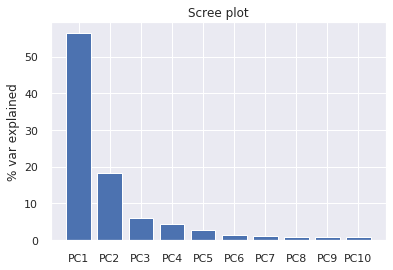

In [7]:
# Criando Scree Plot
top_10_labels = list(PC_table.index)[0:10]

plt.bar(top_10_labels, PC_table.evr_drop_na.head(10) * 100 )
plt.title("Scree plot")
plt.ylabel("% var explained");

In [8]:
evr[0]

0.565280555000852

## Questão 1

Qual fração da variância consegue ser explicada pelo primeiro componente principal de `fifa`? Responda como um único float (entre 0 e 1) arredondado para três casas decimais.

In [9]:
def q1():
    fifa.dropna(inplace = True)
    pca = PCA().fit(fifa)
    evr = pca.explained_variance_ratio_

    return round(float(evr[0]), 3)

## Questão 2

Quantos componentes principais precisamos para explicar 95% da variância total? Responda como un único escalar inteiro.

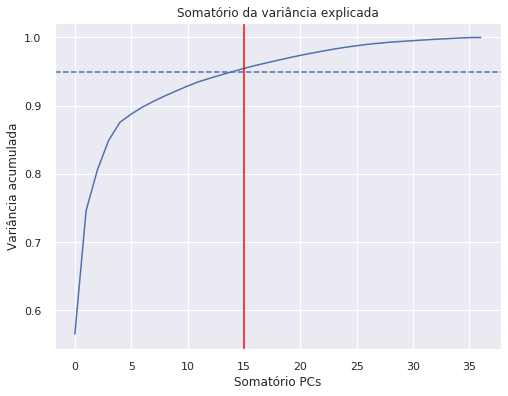

In [10]:
fifa.dropna(inplace = True)
pca = PCA().fit(fifa)
evr = pca.explained_variance_ratio_
# Obtendo vetores soma e índice de PCs
cumsum = np.cumsum(evr)
PC_ID = list(range(len(cumsum)))

pca95 = PCA(0.95).fit(fifa)
evr95 = pca95.explained_variance_ratio_

plt.figure(figsize = (8, 6))
sns.lineplot(PC_ID, cumsum).\
    axes.axhline(0.95, ls = "--").\
    axes.axvline(len(evr95), color = "red")
plt.xlabel("Somatório PCs")
plt.ylabel("Variância acumulada")
plt.title("Somatório da variância explicada");

In [11]:
def q2():
    fifa.dropna(inplace = True)
    pca = PCA(0.95).fit(fifa)

    return len(pca.explained_variance_ratio_)

## Questão 3

Qual são as coordenadas (primeiro e segundo componentes principais) do ponto `x` abaixo? O vetor abaixo já está centralizado. Cuidado para __não__ centralizar o vetor novamente (por exemplo, invocando `PCA.transform()` nele). Responda como uma tupla de float arredondados para três casas decimais.

In [12]:
x = [0.87747123,  -1.24990363,  -1.3191255, -36.7341814,
     -35.55091139, -37.29814417, -28.68671182, -30.90902583,
     -42.37100061, -32.17082438, -28.86315326, -22.71193348,
     -38.36945867, -20.61407566, -22.72696734, -25.50360703,
     2.16339005, -27.96657305, -33.46004736,  -5.08943224,
     -30.21994603,   3.68803348, -36.10997302, -30.86899058,
     -22.69827634, -37.95847789, -22.40090313, -30.54859849,
     -26.64827358, -19.28162344, -34.69783578, -34.6614351,
     48.38377664,  47.60840355,  45.76793876,  44.61110193,
     49.28911284
]

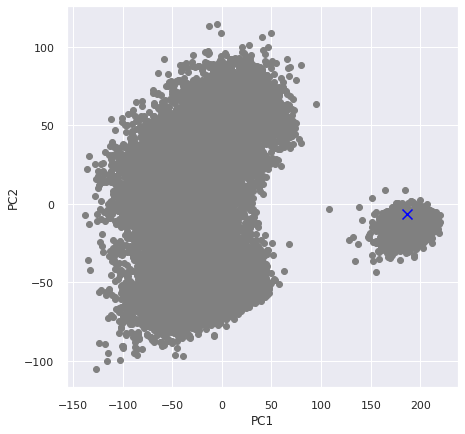

In [13]:
# Selecionando 2 PC
pca = PCA(2).fit(fifa)
# Obtendo matriz de coordenadas dos componentes
pca_coord = pca.transform(fifa)
# Obter centro
components = pca.components_
center = list(components.dot(x))

plt.figure(figsize = (7, 7))
plt.scatter(pca_coord[:, 0], pca_coord[:, 1], c = 'gray')
plt.scatter(center[0], center[1], c = 'blue', marker = "x", s = 100)
plt.xlabel("PC1")
plt.ylabel("PC2");

In [14]:
def q3():
    pca = PCA(2).fit(fifa)
    components = pca.components_
    center = components.dot(x)

    return tuple(center.round(3))

## Questão 4

Realiza RFE com estimador de regressão linear para selecionar cinco variáveis, eliminando uma a uma. Quais são as variáveis selecionadas? Responda como uma lista de nomes de variáveis.

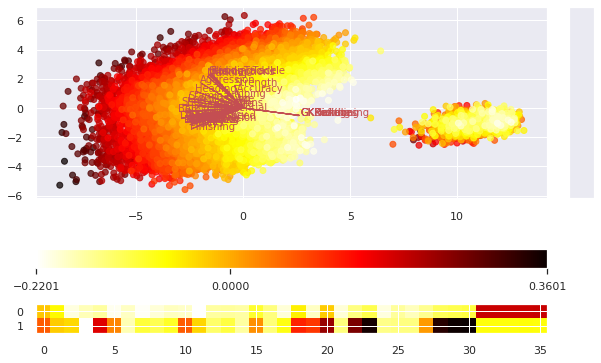

In [15]:
X = fifa.drop(columns = 'Overall')
y = fifa['Overall']

plt.figure(figsize = (10, 6))
yPCA(scale = True, proj_features = True, projection = 2, colormap = 'hot_r', colorbar = True, heatmap = True).fit_transform(X, y);

In [16]:
lm = LinearRegression()
rfe = RFE(lm, n_features_to_select = 5)
rfe.fit(X, y)

select = pd.DataFrame({'bool':rfe.get_support()}, index = X.columns)
select[select['bool'] == True].index.tolist()

['Age', 'Potential', 'BallControl', 'Reactions', 'GKReflexes']

In [17]:
def q4():
    X = fifa.drop(columns = 'Overall')
    y = fifa['Overall']

    lm = LinearRegression()
    rfe = RFE(lm, n_features_to_select = 5)
    rfe.fit(X, y)

    return list(X.columns[rfe.support_])
